In [1]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Imports

In [2]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

tf.keras.backend.clear_session()

## Parameters

In [3]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288
# 576x432
# 512x384
input_res = (384, 288)

seed = 42

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-3,                       
          'nEpoches': 100,                        
          }

ratio_test = 0.85
ratio_val  = 0.8

lib.create_dump([params, seed], dumps_path + "params_du")

type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

## Data loading 

In [4]:
# LOAD & SPLIT DATA ============================================================
'''
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")

'''

'\nmode = 1  #\xa0mode = 0: Random Split\n          #\xa0mode = 1: Split for Patients\n          \ndataset_list = lib.get_dataset_list(\n                                mode, \n                                path_, \n                                imgs_list_path, \n                                params, \n                                ratio_test, \n                                ratio_val, \n                                seed, \n                                modality)\n\n# Dumping splitted data\nlib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")\n\n'

##Loading Data from Pickle

In [5]:
dataset_list = pickle.load(open( f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}", "rb" ))

##Data Augmentation

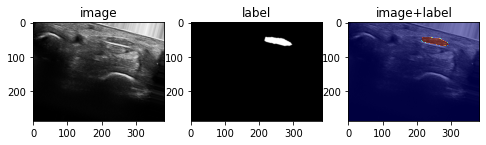

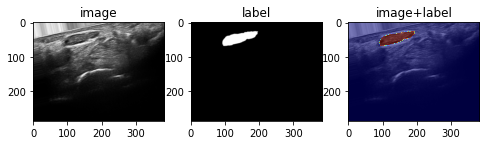

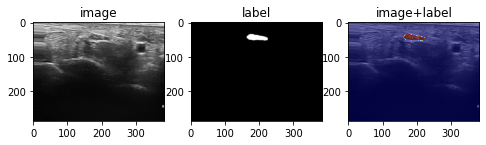

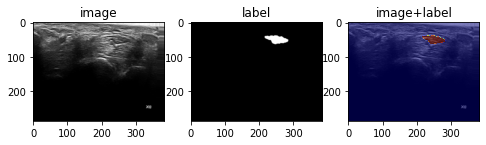

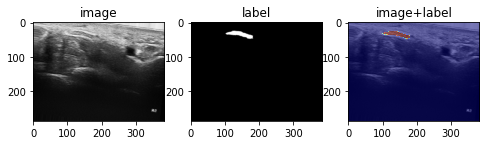

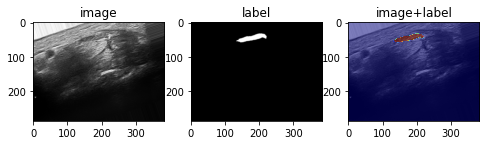

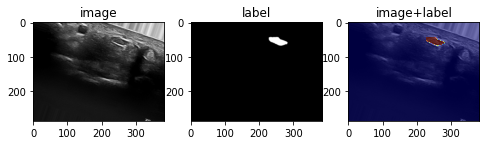

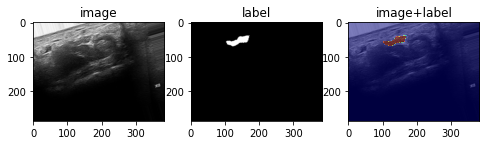

In [6]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

In [7]:
print(params["length_training"])
print(params['length_validation'])
print(len(dataset_list[0]['test']))

164
38
44


# Models

## load models

In [ ]:
from tensorflow import keras
'''
loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

c_objects = {
    "bce_dice_loss": metrics.bce_dice_loss,
    "dice": metrics.dice,
    "iou": metrics.iou,
    "precision": tf.keras.metrics.Precision(),
    "recall": tf.keras.metrics.Recall(),
}

path_trained_models = '/content/drive/MyDrive/CVDL/trained_models/'

path_unet = 'unet'
path_lunet = 'lunet'
path_dblunet = 'dblunet'

model_unet = keras.models.load_model(f'{path_trained_models}/{path_unet}/model.h5', custom_objects=c_objects)
model_lunet = keras.models.load_model(f'{path_trained_models}/{path_lunet}/model.h5', custom_objects=c_objects)
model_dblunet = keras.models.load_model(f'{path_trained_models}/{path_dblunet}/model.h5', custom_objects=c_objects)

model_unet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model_lunet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model_dblunet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)

history_unet = pickle.load(open( f"{path_trained_models}/{path_unet}/train_history", "rb" ))
history_lunet = pickle.load(open( f"{path_trained_models}/{path_lunet}/train_history", "rb" ))
history_dblunet = pickle.load(open( f"{path_trained_models}/{path_dblunet}/train_history", "rb" ))
'''

## train models

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from keras.initializers import glorot_uniform

inputa = Input((input_res[1], input_res[0], 1))
inputs_3ch = Concatenate()([inputa, inputa, inputa])

model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=inputs_3ch)
model.summary()

In [8]:
params['learningRate'] = 1e-3
params['nEpoches'] = 100

models_name = ['unet', 'lightweight_unet', 'dbunet_BN', 'dbunet_BN_vgg16', 'dbunet_BN_ResNet']
arch_name = models_name[4]

!cp "$root_path/modules/models/{arch_name}.py" .
arch = importlib.import_module(arch_name)

input_size = (input_res[1], input_res[0], 1)

initializer = tf.keras.initializers.GlorotUniform()
model = arch.build_model(initializer, input_size)

model_weights = f"{root_path}/dataset/results/models/{arch_name}_Glorot_e{params['nEpoches']}_lr{params['learningRate']}"
#model_weights = "/content/"
log_path = f"{model_weights}/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf $log_path

#model.summary()

ValueError: ignored

In [9]:
model.summary()

NameError: ignored

In [ ]:
loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

print(f'Model wil be saved in {model_weights}')

train_history, model = lib.train(model_weights, log_path, params, model, loss, metric, train_generator, val_generator)
train_history = train_history.history

Model wil be saved in /content/drive/MyDrive/CVDL/dataset/results/models/dbunet_BN_vgg16_Glorot_e100_lr0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
21/21 [==============================] - 46s 1s/step - loss: 1.2372 - dice: 0.0362 - iou: 0.0019 - recall: 0.0442 - precision: 0.0258 - val_loss: 1.0973 - val_dice: 0.0014 - val_iou: 9.3000e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.09727, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/dbunet_BN_vgg16_Glorot_e100_lr0.001/Model.hdf5
Epoch 2/100
21/21 [==============================] - 11s 547ms/step - loss: 0.7613 - dice: 0.2720 - iou: 1.0036e-08 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.0895 - val_dice: 0.0047 - val_iou: 9.3320e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: val_loss improved from 1.09727 to 1.08950, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/dbunet_BN_vgg16_Glorot_e100_lr0.001/Model.hdf5
Epoch 3/100
21/21 [==============================] - 11s 546ms/step - loss: 0.6064 - dice: 0.4204 - iou: 0.0056 - recall: 0.0048 

# Evaluate

### Unet

        dice
0   0.792743
1   0.853874
2   0.761636
3   0.922314
4   0.937095
5   0.904398
6   0.834879
7   0.935678
8   0.922509
9   0.912141
10  0.747493
11  0.907397
12  0.922655
13  0.612403
14  0.773510
15  0.915663
16  0.822447
17  0.375000
18  0.872423
19  0.765565
20  0.819530
21  0.776632
22  0.933411
23  0.936954
24  0.876404
25  0.935504
26  0.880952
27  0.929388
28  0.768473
29  0.938381
30  0.731587
31  0.735733
32  0.874661
33  0.915751
34  0.883203
35  0.858271
36  0.924606
37  0.822718
38  0.878822
39  0.749004
40  0.937649
41  0.906338
42  0.677091
43  0.745136
Average dice: 0.8500703434286011
     dice
17  0.375
Ratio: 0.022727272727272728




Image index 17 - dice: dice    0.375
Name: 17, dtype: float64


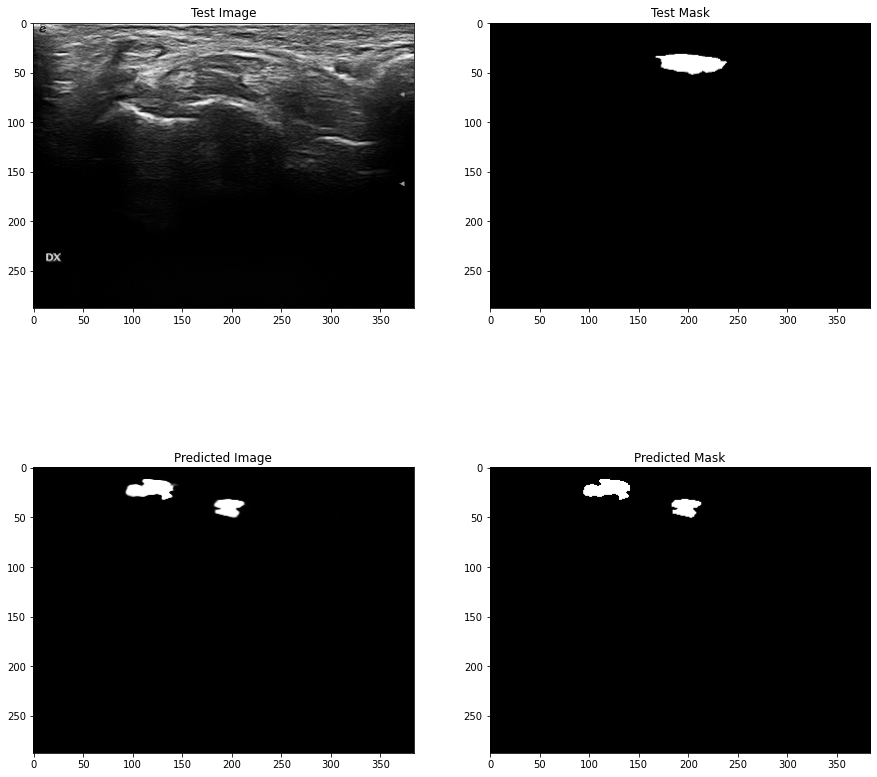

In [ ]:
restults_df = lib.evaluate(dataset_list, model_unet, params)
bad_pred = lib.get_bad_pred(restults_df)
plots.plot_bad_predictions(bad_pred, dataset_list, params, model_unet)

### Lightweight Unet

In [ ]:
restults_df = lib.evaluate(dataset_list, model_lunet, params)
bad_pred = lib.get_bad_pred(restults_df)
plots.plot_bad_predictions(bad_pred, dataset_list, params, model_lunet)

        dice
0   0.695327
1   0.776329
2   0.908989
3   0.897252
4   0.918621
5   0.903818
6   0.878073
7   0.824700
8   0.914986
9   0.934274
10  0.663591
11  0.804945
12  0.918446
13  0.640575
14  0.931378
15  0.913124
16  0.938776
17  0.704264
18  0.888889
19  0.664425
20  0.900249
21  0.873501
22  0.913844
23  0.925234
24  0.846507
25  0.918433
26  0.922061
27  0.903014
28  0.613169
29  0.925114
30  0.836619
31  0.935009
32  0.655621
33  0.933845
34  0.832255
35  0.718497
36  0.769124
37  0.777939
38  0.886937
39  0.753853
40  0.896477
41  0.899679
42  0.814414
43  0.827518
Average dice: 0.8409021114968097
Empty DataFrame
Columns: [dice]
Index: []
Ratio: 0.0


### Double LUnet

In [ ]:
restults_df = lib.evaluate(dataset_list, model_dblunet, params)
bad_pred = lib.get_bad_pred(restults_df)
plots.plot_bad_predictions(bad_pred, dataset_list, params, model_dblunet)

        dice
0   0.860024
1   0.925186
2   0.930312
3   0.913642
4   0.945693
5   0.945473
6   0.913196
7   0.908168
8   0.938356
9   0.937937
10  0.937313
11  0.904893
12  0.926339
13  0.908891
14  0.950678
15  0.935342
16  0.928763
17  0.941118
18  0.879325
19  0.814163
20  0.898998
21  0.924149
22  0.944255
23  0.959441
24  0.932267
25  0.936741
26  0.928105
27  0.923182
28  0.907796
29  0.932954
30  0.812667
31  0.956646
32  0.705882
33  0.943216
34  0.880884
35  0.947687
36  0.926745
37  0.893691
38  0.904203
39  0.825234
40  0.905782
41  0.906819
42  0.799389
43  0.677693
Average dice: 0.9027099356017142
Empty DataFrame
Columns: [dice]
Index: []
Ratio: 0.0


# Plots

### Unet

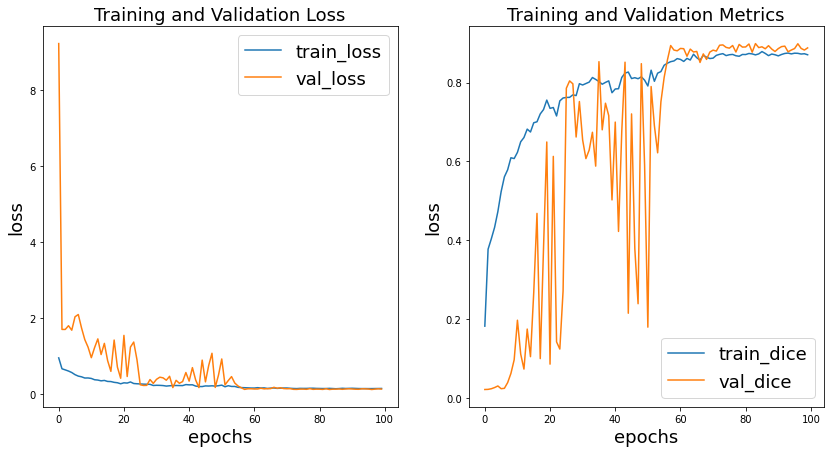

In [ ]:
# Unet
plots.plot_train_metric(history_unet, params['nEpoches'], "dice")
plt.show()

### Lightweight Unet

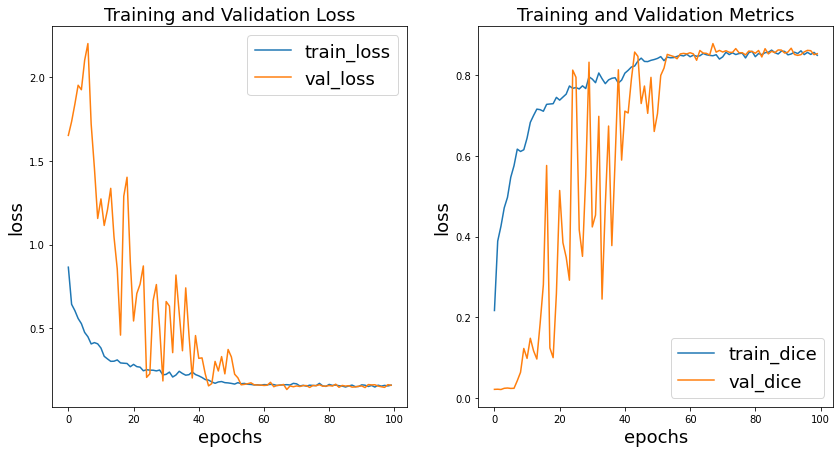

In [ ]:
# LUnet
plots.plot_train_metric(history_lunet, params['nEpoches'], "dice")
plt.show()

### Double LUnet

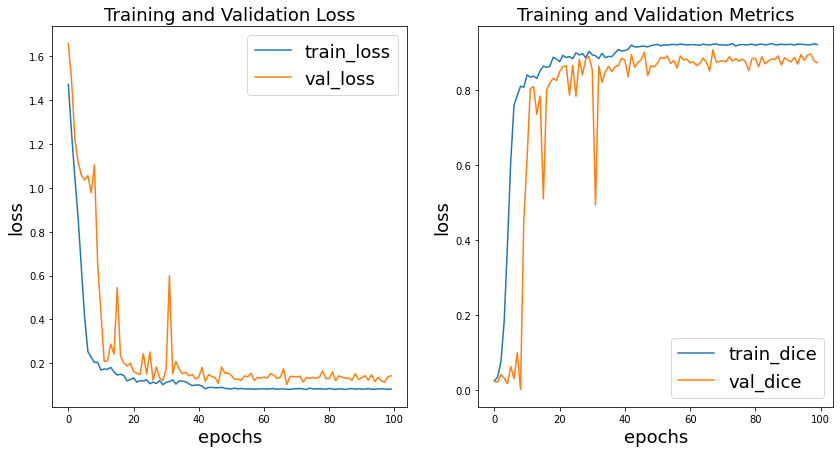

In [ ]:
# DBLUnet
plots.plot_train_metric(history_dblunet, params['nEpoches'], "dice")
plt.show()